In [1]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
from astropy.table import Table

2023-09-20 10:51:55.320334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tfd = tfp.distributions
rng = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
from lcmcmc.preprocessing import add_object_band_index, preprocess_SNANA, extract_subsample

In [4]:
from lcmcmc.utils import get_data_dir_path

In [5]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'

In [6]:
df_head = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

# Load PCs

In [12]:
from kndetect.utils import load_pcs

pcs = load_pcs()

In [13]:
data_dir = get_data_dir_path()

# Load fits

In [14]:
trained_features = pd.read_pickle(os.path.join(data_dir, "train", "train_0_data.pkl"))

In [15]:
trained_features.columns

Index(['SNID', 'MCMC_samples_kn', 'norm_factor', 'sampler_stats_kn',
       'max_time', 'data-likelihood'],
      dtype='object')

# Display results from 10 fits

In [16]:
import matplotlib.pyplot as plt
from lcmcmc.parametric_fits import parametric_fn_pcs

1046     True
1047    False
1048    False
Name: FLT, dtype: bool
634.6297158960205
1046    False
1047     True
1048     True
Name: FLT, dtype: bool
393.6534396934701


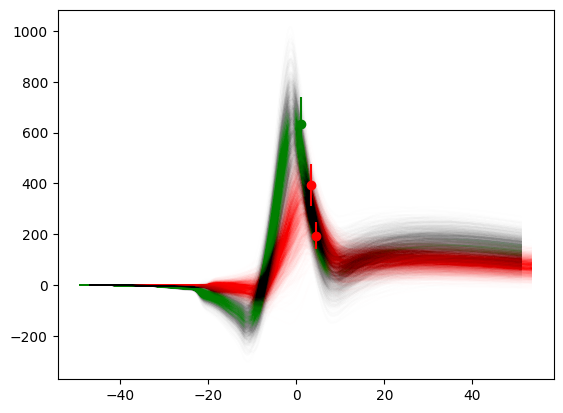

218     True
219     True
220     True
221    False
222    False
223    False
224    False
Name: FLT, dtype: bool
3226.810978286689
218    False
219    False
220    False
221     True
222     True
223     True
224     True
Name: FLT, dtype: bool
4152.281626985227


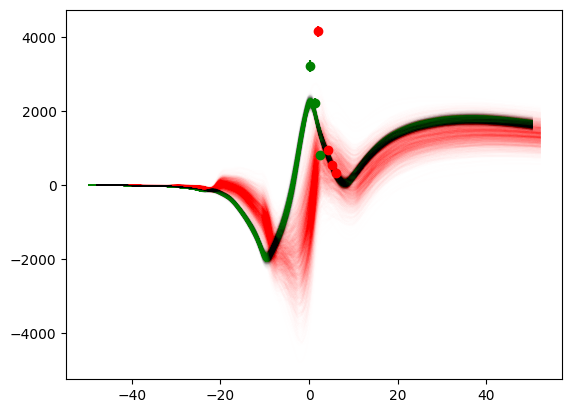

256     True
257    False
258    False
259    False
Name: FLT, dtype: bool
225.634050492394
256    False
257     True
258     True
259     True
Name: FLT, dtype: bool
3580.50906507022


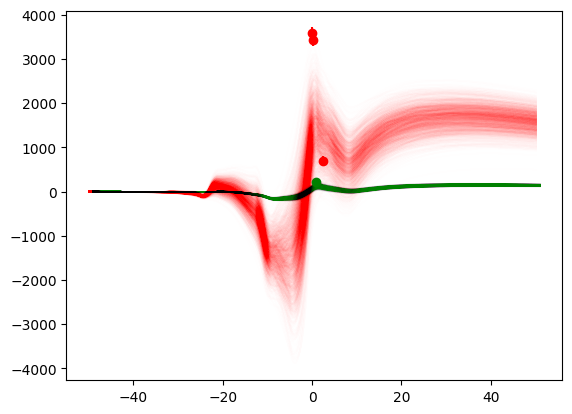

1539     True
1540     True
1541    False
Name: FLT, dtype: bool
1349.7772118091023
1539    False
1540    False
1541     True
Name: FLT, dtype: bool
196.78809869340216


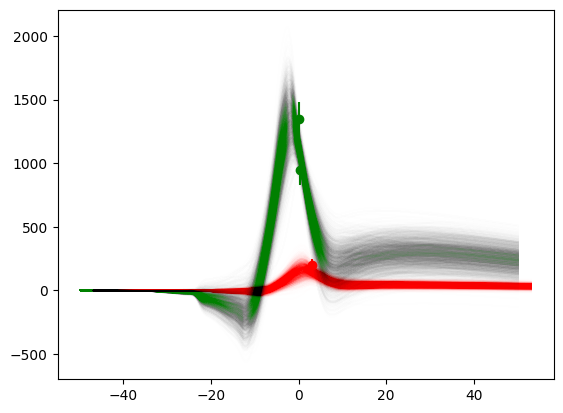

1690     True
1691     True
1692    False
1693    False
Name: FLT, dtype: bool
280.131157960962
1690    False
1691    False
1692     True
1693     True
Name: FLT, dtype: bool
482.6359768686413


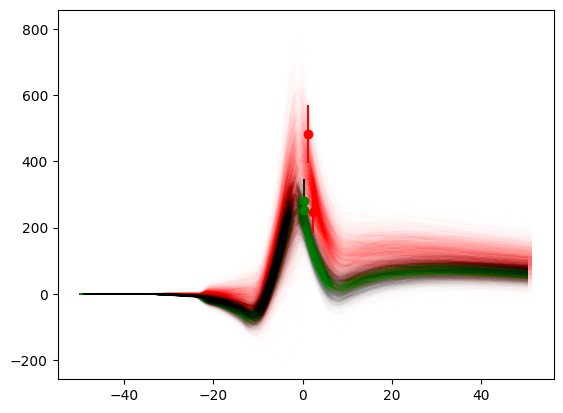

1686     True
1687    False
1688    False
1689    False
Name: FLT, dtype: bool
161.82727794600365
1686    False
1687     True
1688     True
1689     True
Name: FLT, dtype: bool
442.1592951544136


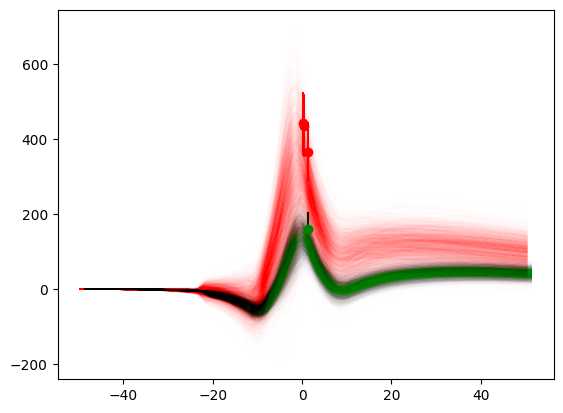

180     True
181     True
182    False
183    False
184    False
185    False
Name: FLT, dtype: bool
2404.7805271050725
180    False
181    False
182     True
183     True
184     True
185     True
Name: FLT, dtype: bool
3479.6476896422764


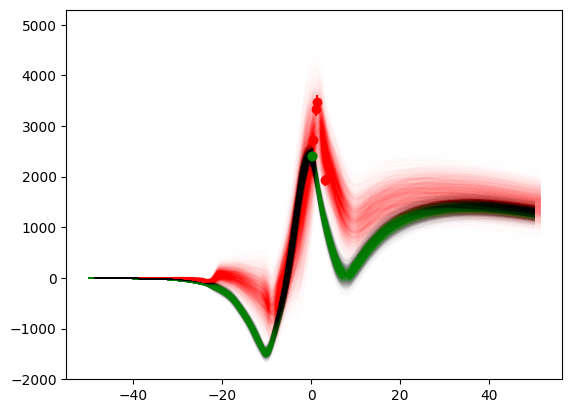

757     True
758     True
759     True
760    False
761    False
Name: FLT, dtype: bool
681.7534742097638
757    False
758    False
759    False
760     True
761     True
Name: FLT, dtype: bool
428.54021341907105


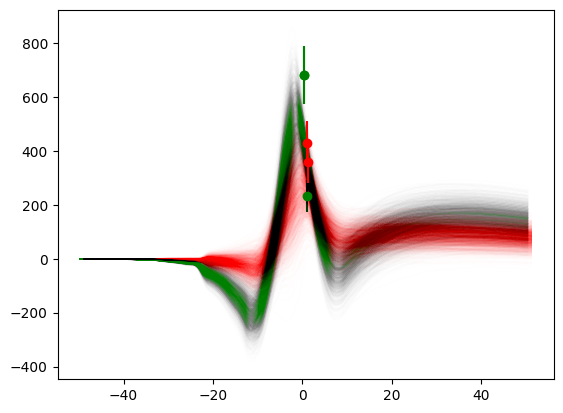

1660     True
1661     True
1662    False
1663    False
1664    False
Name: FLT, dtype: bool
408.96425050234257
1660    False
1661    False
1662     True
1663     True
1664     True
Name: FLT, dtype: bool
1251.5915227815435


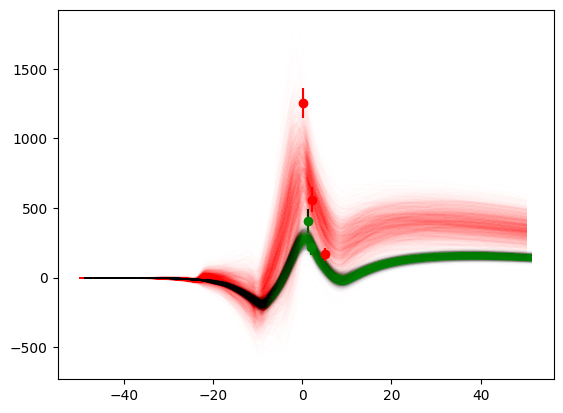

1330     True
1331     True
1332     True
1333    False
1334    False
1335    False
1336    False
Name: FLT, dtype: bool
1202.8557384438275
1330    False
1331    False
1332    False
1333     True
1334     True
1335     True
1336     True
Name: FLT, dtype: bool
2427.53887514501


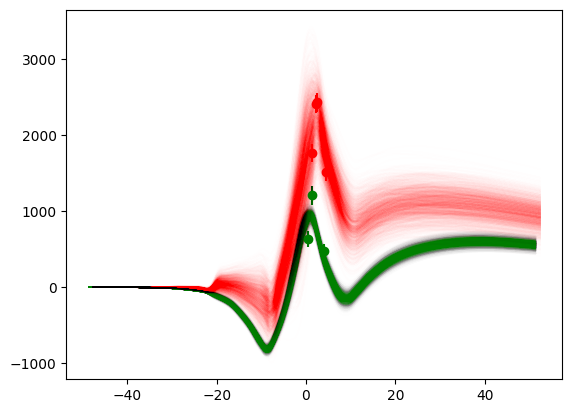

In [17]:
colors = ['g', 'r']
for index, row in trained_features.sample(10).iterrows():

    current_obj_df = {}
    norm_fact = np.array([row['norm_factor']]*2000)

    features = np.concatenate((row['MCMC_samples_kn'], np.expand_dims(np.mean(row['data-likelihood']['data_value'], axis=2), 2)), axis=2).reshape((2000, 7))

    for band_num, band in enumerate(['g', 'r']):
        for coeff_num in range(3):
            current_obj_df[f"{band}coeff{coeff_num}"] = features[:, band_num*3+coeff_num]
    current_obj_df["likelihood"] = features[:, 6]

    current_obj_df["g_norm"] = norm_fact[:, 0]
    current_obj_df["r_norm"] = norm_fact[:, 1]

    current_obj_df=pd.DataFrame(current_obj_df)

    event_type = df_head[row['SNID']==df_head["SNID"]]["SNTYPE"].values[0]
    
    event_df = df_phot[df_phot['SNID'] == row['SNID']]
    
    max_time = row['max_time']
    if len(max_time) == 1:
            max_time = max_time*2
    
    for band_num, band in enumerate([b'g', b'r']):
        print(event_df['FLT'] == band)
        band_df = event_df[event_df['FLT'] == band]
        print(norm_fact[0, band_num])
        
        for pred_num in range(2000):

            #print(mcmc_samples[0].shape)
            c1 = features[pred_num, 0 + band_num*3]
            c2 = features[pred_num, 1 + band_num*3]
            c3 = features[pred_num, 2 + band_num*3]

            predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
            
            plt.plot(np.arange(-50, 50.25, .25)+max_time[band_num], predictions*norm_fact[0, band_num], alpha=.005, color=colors[band_num])
        
        if len(band_df)>0:
            plt.errorbar(band_df["MJD"], band_df["FLUXCAL"], yerr=band_df['FLUXCALERR'], fmt="o", color=colors[band_num])
    plt.show()
    if event_type in [149, 150]:
        current_obj_df["type"]=1

    #features_df.append(current_obj_df)

NOTE that the flux values are normalized. 
To get the actual values, multiply flux and fluxerr columns with norm_factor

In [ ]:
@jax.jit
def run_mcmc_sampling(index, x_range, pcs, mu, scale, observed_sigma, observed_value, rng):
    jd = jd_model_pcs(index, x_range, pcs, mu, scale)
    pinned_jd = jd.experimental_pin(sigma=observed_sigma, obs=observed_value)
    
    # Run the mcmc
    run_mcmc = jax.jit(
        lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
            1000, 
            pinned_jd, 
            n_chains=4, 
            seed=seed,
        )
    )

    rng, sample_rng = jax.random.split(rng, 2)
    mcmc_samples, sampler_stats = run_mcmc(sample_rng)
  
    axes_swapped_mcmc_samples = jax.tree_map(lambda x: np.swapaxes(x, 1, 0), mcmc_samples)

    data_likelihood = jax.vmap(
        jax.vmap(
            lambda x: return_data_loglike(x, obs, pinned_jd)
        )
    )(mcmc_samples)

#     compare_data = az.from_dict(
#         posterior=axes_swapped_mcmc_samples._asdict(),
#         sample_stats={
#             k:np.swapaxes(sampler_stats[k], 1, 0)
#             for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]},
#         log_likelihood=data_likelihood,
#     )

    return mcmc_samples, sampler_stats, data_likelihood

In [ ]:
@jax.jit 
def compute_snr(flux, fluxerr):
    return flux/fluxerr

In [ ]:
kn_snids = df_head[df_head['SNTYPE']==150]['SNID']

In [ ]:
pd.options.mode.chained_assignment = None 
mcmc_samples_kn_prior=[]
mcmc_samples_non_kn_prior=[]
snid_list=[]
sampler_stats_list_kn = []
sampler_stats_list_non_kn = []
norm_factor_list=[]
max_flux_date_list = []
compare_res = []

# for snid in df_head["SNID"].values[:10]:
for snid in kn_snids[:10]:  
    
    compare_dict = {}

    current_df = df_phot[df_phot["SNID"] == snid]
    current_df = add_object_band_index(current_df, bands=[b'g', b'r'])
    
    current_df_head = df_head[df_head["SNID"]==snid]
    
    detection_points = current_df[(current_df["PHOTFLAG"] == 4096) | (current_df["PHOTFLAG"] == 999999)]
    max_snr_loc = np.argmax(comdetection_points["FLUXCAL"].values/detection_points["FLUXCALERR"].values)
    max_snr_date = detection_points["MJD"].values[max_snr_loc]
    
    current_df = current_df[(current_df["MJD"]>= (max_snr_date - 10)) & (current_df["MJD"]<= (max_snr_date +20))]

    normed_current_df = preprocess_SNANA(df_head=current_df_head, df_phot=current_df, bands=[b'g', b'r'], norm_band_index=None)
    
    index = np.zeros((len(normed_current_df), 2), dtype=np.int32)

    index[:, 0] = np.asarray(normed_current_df["object_index"].values)
    index[:, 1] = np.asarray(normed_current_df["band_index"].values)

    x_range = jnp.asarray(normed_current_df["time"])

    observed_value = jnp.array(np.asarray(normed_current_df["flux"]), dtype=jnp.float32)
    observed_sigma = jnp.array(np.asarray(normed_current_df["fluxerr"]), dtype=jnp.float32)

    # use KN prior 
     
    mcmc_samples, sampler_stats, data_likelihood = run_mcmc_sampling(
        index=index, 
        x_range=x_range, 
        pcs=pcs, 
        mu=mu_kn, 
        scale=scale_kn, 
        observed_sigma=observed_sigma, 
        observed_value=observed_value,
        rng=rng,
    )

    sampler_stats_list_kn.append(sampler_stats)
    mcmc_samples_kn_prior.append(mcmc_samples[0])

    # use non-KN prior 
#     pinned_jd, mcmc_samples, sampler_stats, compare_data = run_mcmc_sampling(
#         index=index, 
#         x_range=x_range, 
#         pcs=pcs, 
#         mu=mu_non_kn, 
#         scale=scale_non_kn, 
#         observed_sigma=observed_sigma, 
#         observed_value=observed_value,
#         rng=rng,
#     ) 

    
#     compare_dict["model_non_kn"] = compare_data
#     compare_res.append(compare_dict)
#     mcmc_samples_non_kn_prior.append(mcmc_samples[0])
#     sampler_stats_list_non_kn.append(sampler_stats)
    
    snid_list.append(snid)
    norm_factor_list.append(normed_current_df['norm_factor'][0])
    max_flux_date_list.append(normed_current_df['max_time'][0])


In [ ]:
#mcmc_samples_df = pd.DataFrame({'SNID': snid_list, 'MCMC_samples_kn': mcmc_samples_kn_prior, 'MCMC_samples_non_kn': mcmc_samples_non_kn_prior, 'norm_factor': norm_factor_list , 'sampler_stats_kn': sampler_stats_list_kn, 'sampler_stats_non_kn': sampler_stats_list_non_kn})
mcmc_samples_df = pd.DataFrame({'SNID': snid_list, 'MCMC_samples_kn': mcmc_samples_kn_prior, 'norm_factor': norm_factor_list , 'sampler_stats_kn': sampler_stats_list_kn, 'max_time':max_flux_date_list})

In [ ]:
#az.compare(compare_res[0])

In [ ]:
compare_res[0]['model_kn'].log_likelihood

In [ ]:
az.plot_kde(compare_res[0]['model_kn'].log_likelihood)

In [ ]:
loo = az.loo(compare_res[0]['model_non_kn'], pointwise=True)
az.plot_khat(loo)

In [ ]:
mcmc_samples_df.to_pickle("training_data.pkl")

In [ ]:
read_data = pd.read_pickle("training_data.pkl")

In [ ]:
print(read_data)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
colors = ['r', 'g']
for index, row in read_data.iterrows():
    print(row)
    snid = row["SNID"]
    print(snid)
    
    event_num=0

    current_df_head = df_head[df_head["SNID"] == snid]
    current_df_phot = df_phot[df_phot["SNID"] == snid]
    
    for band_num, band in enumerate([b'g', b'r']):

        band_df = current_df_phot[current_df_phot['FLT']==band]

        plt.errorbar(band_df["MJD"], band_df["FLUXCAL"], yerr=band_df["FLUXCALERR"], fmt="o", color=colors[band_num])
        
        band_max_date = band_df["MJD"].values[np.argmax(band_df["FLUXCAL"].values)]
        for sample_no in range(100):

            sample_no = sample_no + 900
            for chain_num in range(4):

                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band_num*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band_num*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band_num*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(
                    np.arange(-50, 50.25, .25)+mcmc_samples_df['max_time'][0][band_num],
                    predictions*mcmc_samples_df['norm_factor'][0][band_num], 
                    alpha=.01, 
                    color=colors[band_num],
                )

        
    break
    
    print(current_df_head)
    print(current_df_phot['FLT'])
    

In [ ]:
mcmc_samples_df['MCMC_samples_kn']

In [ ]:
colors = ['r', 'g']
num_plot=10
for event_num in range(len(read_data)):
    print(event_num)
    plt.figure()
    object_df = normed_current_df[normed_current_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            sample_no = sample_no + 900
            for chain_num in range(4):
                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])

        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    
    plt.show()
    break

In [ ]:
colors = ['r', 'g']
num_plot=10
for event_num in [0]:
    print(event_num)
    plt.figure()
    object_df = normed_current_df[normed_current_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            sample_no = sample_no + 900
            for chain_num in range(4):
                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])
                
#                 c1 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 0 + band*3]
#                 c2 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 1 + band*3]
#                 c3 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 2 + band*3]
                
#                 predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
#                 plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    
    plt.show()
    break